# Trading Platform Customer Attrition Risk Prediction using sklearn

There are many users of online trading platforms and these companies would like to run analytics on and predict churn based on user activity on the platform. Since competition is rife, keeping customers happy so they do not move their investments elsewhere is key to maintaining profitability.

In this notebook, we will leverage Watson Studio Local (that is a service on IBM Cloud Pak for Data) to do the following:

1. Ingest merged customer demographics and trading activity data
2. Visualize merged dataset and get better understanding of data to build hypotheses for prediction
3. Leverage sklearn library to build classification model that predicts whether customer has propensity to churn
4. Expose the classification model as RESTful API endpoint for the end-to-end customer churn risk prediction and risk remediation application

<img src="https://github.com/burtvialpando/CloudPakWorkshop/blob/master/CPD/images/NotebookImage.png?raw=true" width="800" height="500" align="middle"/>


<a id="top"></a>
## Table of Contents

1. [Load libraries](#load_libraries)
2. [Load and visualize merged customer demographics and trading activity data](#load_data)
3. [Prepare data for building classification model](#prepare_data)
4. [Train classification model and test model performance](#build_model)
5. [Save model to ML repository and expose it as REST API endpoint](#save_model)
6. [Summary](#summary)

### Quick set of instructions to work through the notebook

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. The notebook has 2 types of cells - markdown (text) such as this and code such as the one below. 
2. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
3. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
4. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

<a id="load_libraries"></a>
## 1. Load libraries
[Top](#top)

Running the following cell will load all libraries needed to load, visualize, prepare the data and build ML models for our use case

In [1]:
#Uncomment and run once to install the package in your runtime environment
!pip install sklearn-pandas

In [2]:
# If the following cell doesn't work, please un-comment out the next line and do upgrade the patplotlib package. When the upgrade is done, restart the kernal and start from the beginning again. 
!pip install --user --upgrade matplotlib

     |████████████████████████████████| 12.4 MB 9.0 MB/s eta 0:00:01


In [3]:
import brunel
import pandas as pd
import numpy as np
import sklearn.pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import json
import matplotlib.pyplot as plt
%matplotlib inline

<a id="load_data"></a>
## 2. Load data example
[Top](#top)

Data can be easily loaded within ICPD using point-and-click functionality. The following image illustrates how to load a merged dataset assuming it is called "customer_demochurn_activity_analyze.csv". The file can be located by its name and inserted into the notebook as a **pandas** dataframe as shown below:

<img src="https://github.com/burtvialpando/CloudPakWorkshop/blob/master/CPD/images/InsertPandasDataFrame.png?raw=true" width="300" height="300" align="middle"/>

The interface comes up with a generic name, so it is good practice to rename the dataframe to match context of the use case. In this case, we will use df_churn.

In [4]:

df_churn_pd = pd.read_csv('/project_data/data_asset/customer_demochurn_activity_analyze.csv')
df_churn_pd.head()


,ID,AGE_GROUP,CHURNRISK,GENDER,STATUS,CHILDREN,ESTINCOME,HOMEOWNER,AGE,TAXID,...,LATITUDE,TOTALDOLLARVALUETRADED,TOTALUNITSTRADED,LARGESTSINGLETRANSACTION,SMALLESTSINGLETRANSACTION,PERCENTCHANGECALCULATION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD
0,0,Young adult,Low,F,S,1,38000.00,N,24,147889187,...,NaN,59755.98,206,29877,2987,51.50,3,10,2987.799,0.0000
1,1,Adult,Low,M,M,2,29616.00,N,49,113772166,...,38.687261,29782.98,45,14891,1489,11.25,3,9,1489.149,0.0000
2,2,Adult,Low,M,M,0,19732.80,N,51,132420919,...,NaN,24812.48,22,12406,1240,5.50,1,9,1240.624,0.0000
3,3,Adult,High,M,S,2,96.33,N,56,700548452,...,32.531971,26132.61,32,13066,1306,8.00,3,5,0.000,1306.6305
4,4,Young adult,High,F,M,2,52004.80,N,25,141013706,...,33.593192,5030.50,23,1257,125,3.45,2,19,0.000,251.5250


Data Visualization is key step in data mining process that helps better understand data before it can be prepared for building ML models

We use Brunel library that comes preloaded within Watson Studio local environment to visualize the merged customer data. 

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and business users. More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

Try Brunel visualization here: http://brunel.mybluemix.net/gallery_app/renderer

In [5]:
df_churn_pd.dtypes

ID                             int64
AGE_GROUP                     object
CHURNRISK                     object
GENDER                        object
STATUS                        object
CHILDREN                       int64
ESTINCOME                    float64
HOMEOWNER                     object
AGE                            int64
TAXID                          int64
CREDITCARD                     int64
DOB                            int64
ADDRESS_1                     object
ADDRESS_2                    float64
CITY                          object
STATE                         object
ZIP                            int64
ZIP4                           int64
LONGITUDE                    float64
LATITUDE                     float64
TOTALDOLLARVALUETRADED       float64
TOTALUNITSTRADED               int64
LARGESTSINGLETRANSACTION       int64
SMALLESTSINGLETRANSACTION      int64
PERCENTCHANGECALCULATION     float64
DAYSSINCELASTLOGIN             int64
DAYSSINCELASTTRADE             int64
N

In [6]:
df_churn_pd.describe()

,ID,CHILDREN,ESTINCOME,AGE,TAXID,CREDITCARD,DOB,ADDRESS_2,ZIP,ZIP4,...,LATITUDE,TOTALDOLLARVALUETRADED,TOTALUNITSTRADED,LARGESTSINGLETRANSACTION,SMALLESTSINGLETRANSACTION,PERCENTCHANGECALCULATION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD
count,2066.000000,2066.000000,2066.000000,2066.000000,2.066000e+03,2.066000e+03,2.066000e+03,0.0,2066.000000,2066.000000,...,575.000000,2066.000000,2066.000000,2066.000000,2066.000000,2066.000000,2066.000000,2066.000000,2066.000000,2066.000000
mean,1032.500000,1.146176,51514.070465,42.802033,3.421543e+08,5.142340e+15,1.949260e+07,NaN,41861.578896,454.178606,...,38.363778,16141.207609,58.594385,7734.534850,773.172314,13.346854,2.903195,9.355276,364.559448,426.145109
std,596.547148,0.843105,30805.652721,14.919932,2.703026e+08,2.442024e+15,2.818342e+05,NaN,31189.897089,1497.548554,...,5.321106,9920.982916,57.656443,5314.075773,531.396346,13.961391,1.498448,4.250351,536.820452,535.531833
min,0.000000,0.000000,96.330000,12.000000,1.383794e+07,1.002445e+15,1.900010e+07,NaN,601.000000,0.000000,...,21.329168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,516.250000,0.000000,21021.600000,30.250000,1.474227e+08,3.003486e+15,1.925035e+07,NaN,11104.250000,0.000000,...,34.291090,8090.810000,15.000000,2022.000000,202.000000,3.250000,2.000000,6.250000,0.000000,0.000000
50%,1032.500000,1.000000,55860.000000,46.000000,1.951132e+08,5.156748e+15,1.949012e+07,NaN,36608.000000,0.000000,...,40.224029,16141.610000,39.000000,8070.000000,807.000000,8.250000,3.000000,9.000000,0.000000,143.014250
75%,1548.750000,2.000000,78000.000000,54.000000,5.203421e+08,7.304196e+15,1.973057e+07,NaN,72752.500000,0.000000,...,41.743316,22992.300000,87.000000,11496.000000,1149.000000,20.000000,4.000000,11.000000,807.080500,809.330875
max,2065.000000,2.000000,120000.000000,77.000000,9.999949e+08,9.889241e+15,1.999122e+07,NaN,98631.000000,9920.000000,...,48.598100,59755.980000,332.000000,29877.000000,2987.000000,83.000000,5.000000,20.000000,2987.799000,2950.295000


In [7]:
%brunel data('df_churn_pd') stack polar bar x(CHURNRISK) y(#count) color(CHURNRISK) bar tooltip(#all)

<IPython.core.display.Javascript object>

In [8]:
%brunel data('df_churn_pd') bar x(STATUS) y(#count) color(STATUS) tooltip(#all) | stack bar x(STATUS) y(#count) color(CHURNRISK: pink-orange-yellow) bin(STATUS) sort(STATUS) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

In [9]:
%brunel data('df_churn_pd') bar x(TOTALUNITSTRADED) y(#count) color(CHURNRISK: pink-gray-orange) sort(STATUS) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

In [10]:
%brunel data('df_churn_pd') bar x(DAYSSINCELASTTRADE) y(#count) color(CHURNRISK: pink-gray-orange) sort(STATUS) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

<a id="prepare_data"></a>
## 3. Data preparation
[Top](#top)

Data preparation is a very important step in machine learning model building. This is because the model can perform well only when the data it is trained on is good and well prepared. Hence, this step consumes bulk of data scientist's time spent building models.

During this process, we identify categorical columns in the dataset. Categories needed to be indexed, which means the string labels are converted to label indices. These label indices and encoded using One-hot encoding to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values. This encoding allows algorithms which expect continuous features to use categorical features.

Final step in the data preparation process is to assemble all the categorical and non-categorical columns into a feature vector. We use VectorAssembler for this. VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models.

#### Use the DataFrameMapper class to declare transformations and variable imputations.

* LabelBinarizer - Converts a categorical variable into a dummy variable (aka binary variable)
* StandardScaler - Standardize features by removing the mean and scaling to unit variance, z = (x - u) / s

See docs: 
* https://github.com/scikit-learn-contrib/sklearn-pandas
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer
* https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [11]:
# Defining the categorical columns 
categoricalColumns = ['GENDER', 'STATUS', 'HOMEOWNER', 'AGE_GROUP']
numericColumns = ['CHILDREN', 'ESTINCOME', 'TOTALDOLLARVALUETRADED', 'TOTALUNITSTRADED', 'LARGESTSINGLETRANSACTION', 'SMALLESTSINGLETRANSACTION', 
                          'PERCENTCHANGECALCULATION', 'DAYSSINCELASTLOGIN', 'DAYSSINCELASTTRADE', 'NETREALIZEDGAINS_YTD', 'NETREALIZEDLOSSES_YTD']

In [12]:
mapper = DataFrameMapper([
    (['GENDER'], LabelBinarizer()),
    (['STATUS'], LabelBinarizer()),
    (['HOMEOWNER'], LabelBinarizer()),
    (['AGE_GROUP'], LabelBinarizer()),
    (['CHILDREN'],  StandardScaler()),
    (['ESTINCOME'],  StandardScaler()),
    (['TOTALDOLLARVALUETRADED'],  StandardScaler()),
    (['TOTALUNITSTRADED'],  StandardScaler()),
    (['LARGESTSINGLETRANSACTION'],  StandardScaler()),
    (['SMALLESTSINGLETRANSACTION'],  StandardScaler()),
    (['PERCENTCHANGECALCULATION'],  StandardScaler()),
    (['DAYSSINCELASTLOGIN'],  StandardScaler()),
    (['DAYSSINCELASTTRADE'],  StandardScaler()),
    (['NETREALIZEDGAINS_YTD'],  StandardScaler()),
    (['NETREALIZEDLOSSES_YTD'],  StandardScaler())], default=False)

In [13]:
df_churn_pd.columns

Index(['ID', 'AGE_GROUP', 'CHURNRISK', 'GENDER', 'STATUS', 'CHILDREN',
       'ESTINCOME', 'HOMEOWNER', 'AGE', 'TAXID', 'CREDITCARD', 'DOB',
       'ADDRESS_1', 'ADDRESS_2', 'CITY', 'STATE', 'ZIP', 'ZIP4', 'LONGITUDE',
       'LATITUDE', 'TOTALDOLLARVALUETRADED', 'TOTALUNITSTRADED',
       'LARGESTSINGLETRANSACTION', 'SMALLESTSINGLETRANSACTION',
       'PERCENTCHANGECALCULATION', 'DAYSSINCELASTLOGIN', 'DAYSSINCELASTTRADE',
       'NETREALIZEDGAINS_YTD', 'NETREALIZEDLOSSES_YTD'],
      dtype='object')

In [14]:
# Define input data to the model
X = df_churn_pd.drop(['ID','CHURNRISK','AGE','TAXID','CREDITCARD','DOB','ADDRESS_1', 'ADDRESS_2', 'CITY', 'STATE', 'ZIP', 'ZIP4', 'LONGITUDE',
       'LATITUDE'], axis=1)

In [15]:
X.shape

(2066, 15)

In [16]:
# Define the target variable and encode with value between 0 and n_classes-1
le = LabelEncoder()
y = le.fit_transform(df_churn_pd['CHURNRISK'])

In [17]:
# split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

<a id="build_model"></a>
## 4. Build Random Forest classification model
[Top](#top)

We instantiate a decision-tree based classification algorithm, namely, RandomForestClassifier. Next we define a pipeline to chain together the various transformers and estimaters defined during the data preparation step before. Sklearn standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow.

We split original dataset into train and test datasets. We fit the pipeline to training data and apply the trained model to transform test data and generate churn risk class prediction

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
# Instantiate the Classifier
random_forest = RandomForestClassifier(random_state=5)

# Define the steps in the pipeline to sequentially apply a list of transforms and the estimator, i.e. RandomForestClassifier
steps = [('mapper', mapper),('RandonForestClassifier', random_forest)]
pipeline = sklearn.pipeline.Pipeline(steps)

# train the model
model=pipeline.fit( X_train, y_train )

model

Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['GENDER'],
                                            LabelBinarizer(neg_label=0,
                                                           pos_label=1,
                                                           sparse_output=False)),
                                           (['STATUS'],
                                            LabelBinarizer(neg_label=0,
                                                           pos_label=1,
                                                           sparse_output=False)),
                                           (['HOMEOWNER'],
                                            LabelBinarizer(neg_label=0,
                                                           pos_label=1,
                                                           sparse_output=False)),
                                        

In [20]:
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = model.predict( X_test )


In [21]:
# show first 10 rows of predictions
y_prediction[0:10,]

array([1, 0, 0, 0, 0, 2, 2, 1, 1, 1])

In [22]:
# show first 10 rows of predictions with the corresponding labels
le.inverse_transform(y_prediction)[0:10]

array(['Low', 'High', 'High', 'High', 'High', 'Medium', 'Medium', 'Low',
       'Low', 'Low'], dtype=object)

### Model results

In a supervised classification problem such as churn risk classification, we have a true output and a model-generated predicted output for each data point. For this reason, the results for each data point can be assigned to one of four categories:

1. True Positive (TP) - label is positive and prediction is also positive
2. True Negative (TN) - label is negative and prediction is also negative
3. False Positive (FP) - label is negative but prediction is positive
4. False Negative (FN) - label is positive but prediction is negative

These four numbers are the building blocks for most classifier evaluation metrics. A fundamental point when considering classifier evaluation is that pure accuracy (i.e. was the prediction correct or incorrect) is not generally a good metric. The reason for this is because a dataset may be highly unbalanced. For example, if a model is designed to predict fraud from a dataset where 95% of the data points are not fraud and 5% of the data points are fraud, then a naive classifier that predicts not fraud, regardless of input, will be 95% accurate. For this reason, metrics like precision and recall are typically used because they take into account the type of error. In most applications there is some desired balance between precision and recall, which can be captured by combining the two into a single metric, called the F-measure.

In [23]:
# display label mapping to assist with interpretation of the model results
label_mapping=le.inverse_transform([0,1,2])
print('0: ', label_mapping[0])
print('1: ', label_mapping[1])
print('2: ', label_mapping[2])

0:  High
1:  Low
2:  Medium


In [24]:
### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )

### and print the report
print(report)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       318
           1       0.99      1.00      0.99       198
           2       0.88      0.74      0.80       104

    accuracy                           0.94       620
   macro avg       0.93      0.90      0.91       620
weighted avg       0.94      0.94      0.94       620



In [25]:
print('Accuracy:   ',sklearn.metrics.accuracy_score( y_test, y_prediction ))

Accuracy:    0.9387096774193548


#### Get the column names of the transformed features

In [26]:
m_step=pipeline.named_steps['mapper']

In [27]:
m_step.transformed_names_

['GENDER',
 'STATUS_D',
 'STATUS_M',
 'STATUS_S',
 'HOMEOWNER',
 'AGE_GROUP_Adult',
 'AGE_GROUP_Child',
 'AGE_GROUP_Senior',
 'AGE_GROUP_Young adult',
 'CHILDREN',
 'ESTINCOME',
 'TOTALDOLLARVALUETRADED',
 'TOTALUNITSTRADED',
 'LARGESTSINGLETRANSACTION',
 'SMALLESTSINGLETRANSACTION',
 'PERCENTCHANGECALCULATION',
 'DAYSSINCELASTLOGIN',
 'DAYSSINCELASTTRADE',
 'NETREALIZEDGAINS_YTD',
 'NETREALIZEDLOSSES_YTD']

In [28]:
features = m_step.transformed_names_

In [29]:
# Get the features importance
importances = pipeline.named_steps['RandonForestClassifier'][1].feature_importances_
indices = np.argsort(importances)

Text(0.5, 0, 'Relative Importance')

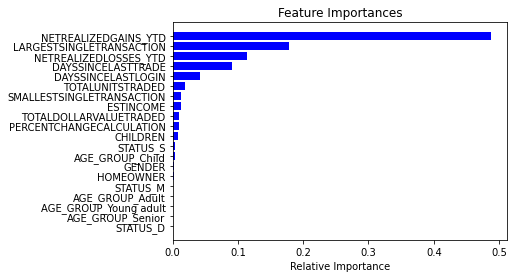

In [30]:
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b',align='center')
plt.yticks(range(len(indices)), (np.array(features))[indices])
plt.xlabel('Relative Importance')

<a id="save_model"></a>
## 5. Save the model into WML Deployment Space
[Top](#top)

Before we save the model we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space.

The steps involved for saving and deploying the model are as follows:

1. Create a new deployment space. Enter the name of the space in the cell below. If a space with specified space_name already exists, existing space will be deleted before creating a new space.
2. Set this deployment space as the default space.
3. Store the model pipeline in the deployment space. Enter the name for the model in the cell below. 
4. Deploy the saved model. Enter the deployment name in the cell below. 
5. Retrieve the scoring endpoint to score the model with a payload
6. We will use the watson_machine_learning_client package to complete these steps. 

In [31]:
!pip install watson-machine-learning-client-v4

In [35]:
# Specify a names for the space being created, the saved model and the model deployment
space_name = 'deployment-space-analytics-project-workshop'

model_name = 'churn_risk_model'

deployment_name = 'churn_risk_model-deployment'

In [36]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

import os
token = os.environ['USER_ACCESS_TOKEN']

from project_lib.utils import environment
url = environment.get_common_api_url()

wml_credentials = {
"token": token,
"instance_id" : "wml_local",
"url": url,
"version": "3.0.0"
}

client = WatsonMachineLearningAPIClient(wml_credentials)

If a space with specified space_name already exists, delete the existing space before creating a new one.

In [37]:

for space in client.spaces.get_details()['resources']:
    if space_name in space['entity']['name']:
        client.spaces.delete(space['metadata']['guid'])
        print(space_name, "is deleted")

### 5.1 Create Deployment Space

In [39]:
# create the space and set it as default
space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name
}

stored_space_details = client.spaces.store(space_meta_data)

space_uid = stored_space_details['metadata']['guid']

# set the newly created deployment space as the default
client.set.default_space(space_uid)

'SUCCESS'

In [40]:
# fetching details of the space created
stored_space_details

{'metadata': {'name': 'deployment-space-analytics-project-workshop',
  'role': 'Admin',
  'guid': 'c1abe603-98ec-422d-b73b-61c1531589f8',
  'id': 'c1abe603-98ec-422d-b73b-61c1531589f8',
  'created_at': '2020-06-01T20:27:45.579Z',
  'owner': '1000331001',
  'href': '/v4/spaces/c1abe603-98ec-422d-b73b-61c1531589f8'},
 'entity': {'name': 'deployment-space-analytics-project-workshop',
  'assets': {'experiments': [],
   'pipelines': [],
   'runtimes': [],
   'libraries': [],
   'data_references': [],
   'models': [],
   'functions': []}}}

### 5.2 Store the model in the deployment space

In [42]:
# list all supported software specs
client.software_specifications.list()

--------------------------  ------------------------------------  ----
NAME                        ASSET_ID                              TYPE
default_py3.6               0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
scikit-learn_0.20-py3.6     09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
ai-function_0.1-py3.6       0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                  0e6e79df-875e-4f24-8ae9-62dcc2148306  base
pytorch_1.1-py3.6           10ac12d6-6b30-4ccd-8392-3e922c096a92  base
scikit-learn_0.22-py3.6     154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
tensorflow_1.15-py3.6       2b73a275-7cbf-420b-a912-eae7f436e0bc  base
pytorch_1.2-py3.6           2c8ef57d-2687-4b7d-acce-01f94976dac1  base
spark-mllib_2.3             2e51f700-bca0-4b0d-88dc-5c6791338875  base
pytorch-onnx_1.1-py3.6-edt  32983cea-3f32-4400-8965-dde874a8d67e  base
spark-mllib_2.4             390d21f8-e58b-4fac-9c55-d7ceda621326  base
xgboos

In [41]:
# run this line if you do not know the version of scikit-learn that was used to build the model
!pip show scikit-learn

Name: scikit-learn
Version: 0.22.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages
Requires: scipy, joblib, numpy
Required-by: sklearn-pandas


In [43]:
software_spec_uid = client.software_specifications.get_uid_by_name('scikit-learn_0.22-py3.6')

In [44]:
metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.22"
}

stored_model_details = client.repository.store_model(pipeline,
                                               meta_props=metadata,
                                               training_data=X_train,
                                               training_target=y_train)

In [45]:
stored_model_details

{'metadata': {'name': 'churn_risk_model',
  'guid': '35442cf6-2df4-4a6a-aa5b-2bae010dc47a',
  'id': '35442cf6-2df4-4a6a-aa5b-2bae010dc47a',
  'modified_at': '2020-06-01T20:33:23.002Z',
  'created_at': '2020-06-01T20:33:21.002Z',
  'owner': '1000331001',
  'href': '/v4/models/35442cf6-2df4-4a6a-aa5b-2bae010dc47a?space_id=c1abe603-98ec-422d-b73b-61c1531589f8',
  'space_id': 'c1abe603-98ec-422d-b73b-61c1531589f8'},
 'entity': {'name': 'churn_risk_model',
  'training_data_references': [{'location': {'bucket': 'not_applicable'},
    'type': 'fs',
    'connection': {'access_key_id': 'not_applicable',
     'secret_access_key': 'not_applicable',
     'endpoint_url': 'not_applicable'},
    'schema': {'id': '1',
     'type': 'DataFrame',
     'fields': [{'name': 'AGE_GROUP', 'type': 'object'},
      {'name': 'GENDER', 'type': 'object'},
      {'name': 'STATUS', 'type': 'object'},
      {'name': 'CHILDREN', 'type': 'int64'},
      {'name': 'ESTINCOME', 'type': 'float64'},
      {'name': 'HOMEOWNE

### 5.3 Create a deployment for the stored model

In [46]:
# deploy the model
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

# deploy the model

model_uid = stored_model_details["metadata"]["guid"]
deployment_details = client.deployments.create( artifact_uid=model_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: '35442cf6-2df4-4a6a-aa5b-2bae010dc47a' started

#######################################################################################


initializing...............................................
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='47f616e1-66d9-49f3-991a-f0b371627c66'
------------------------------------------------------------------------------------------------




### 5.4 Score the model

In [47]:
# retrieve the scoring endpoint
scoring_endpoint = client.deployments.get_scoring_href(deployment_details)

print('Scoring Endpoint:   ',scoring_endpoint)

Scoring Endpoint:    https://internal-nginx-svc:12443/v4/deployments/47f616e1-66d9-49f3-991a-f0b371627c66/predictions


In [48]:
scoring_deployment_id = client.deployments.get_uid(deployment_details)
client.deployments.get_details(scoring_deployment_id)

{'metadata': {'parent': {'href': ''},
  'name': 'churn_risk_model-deployment',
  'guid': '47f616e1-66d9-49f3-991a-f0b371627c66',
  'description': '',
  'id': '47f616e1-66d9-49f3-991a-f0b371627c66',
  'modified_at': '2020-06-01T20:34:56.680Z',
  'created_at': '2020-06-01T20:34:56.680Z',
  'href': '/v4/deployments/47f616e1-66d9-49f3-991a-f0b371627c66',
  'space_id': 'c1abe603-98ec-422d-b73b-61c1531589f8'},
 'entity': {'name': 'churn_risk_model-deployment',
  'custom': {},
  'online': {},
  'description': '',
  'space': {'id': 'c1abe603-98ec-422d-b73b-61c1531589f8',
   'href': '/v4/spaces/c1abe603-98ec-422d-b73b-61c1531589f8'},
  'status': {'state': 'ready',
   'online_url': {'url': 'https://internal-nginx-svc:12443/v4/deployments/47f616e1-66d9-49f3-991a-f0b371627c66/predictions'}},
  'asset': {'id': '35442cf6-2df4-4a6a-aa5b-2bae010dc47a',
   'href': '/v4/models/35442cf6-2df4-4a6a-aa5b-2bae010dc47a?space_id=c1abe603-98ec-422d-b73b-61c1531589f8'},
  'space_id': 'c1abe603-98ec-422d-b73b-61c

In [49]:
payload = [{"values": [ ['Young adult','M','S', 2,56000, 'N', 5030, 23, 2257, 125, 3.45, 2, 19, 1200, 251]]}]

In [50]:
payload_metadata = {client.deployments.ScoringMetaNames.INPUT_DATA: payload}
# score
predictions = client.deployments.score(scoring_deployment_id, payload_metadata)
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [[0, [0.72, 0.23, 0.05]]]}]}

In [51]:
# display label mapping to assist with interpretation of the model results
label_mapping=le.inverse_transform([0,1,2])
print('0: ', label_mapping[0])
print('1: ', label_mapping[1])
print('2: ', label_mapping[2])

0:  High
1:  Low
2:  Medium


#### Write test data into .csv files for batch scoring and model evaluations

In [54]:
# Write the test data a .csv so that we can later use it for batch scoring
write_score_CSV=X_test
write_score_CSV.to_csv('/project_data/data_asset/model_batch_score.csv', sep=',', index=False)

In [55]:
# Write the test data to a .csv so that we can later use it for Evaluation
write_eval_CSV=X_test
write_eval_CSV.to_csv('/project_data/data_asset/model_eval.csv', sep=',', index=False)

**Last updated:** 06/01/2020 - Notebook by Anjali Shah and Sidney Phoon. Updates by Burt Vialpando.